In [20]:
%load_ext autoreload
%autoreload 2

from pathlib import Path

from icecream import ic
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.decomposition import PCA
from tqdm import trange

import torch
from torch import nn
import torch.nn.functional as F

from mech_int_othelloGPT.tl_othello_utils import (
    stoi,
    ALPHA,
    COLUMNS,
    STARTING_SQUARES,
    load_hooked_model,
)
from mech_int_othelloGPT.utils import set_seed
from mech_int_othelloGPT.board_probe import (
    train as train_linear,
    evaluate
)
from mech_int_othelloGPT.mid_probe import (
    train as train_mid,
    evaluate as evaluate_mid
)
from mech_int_othelloGPT.intervene import intervene

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
set_seed(24601)

PAPER_CODE_DIR = Path("mech_int_othelloGPT")
PROBE_DIR = PAPER_CODE_DIR / "mech_int" / "probes"
NEW_PROBE_DIR = Path("new_probes")
DATA_DIR = PAPER_CODE_DIR / "data"

MID_PROBE_DIR = NEW_PROBE_DIR / "mid"
LINEAR_PROBE_DIR = PROBE_DIR / "linear"
FLIPPED_PROBE_DIR = PROBE_DIR / "flipped"

ALL_SQUARES = [s for s in range(64)]
NON_STARTING_SQUARES = [s for s in ALL_SQUARES if s not in STARTING_SQUARES]

In [3]:
class Cell:
    """Various cell representations in one place."""
    def __init__(self, string_: int):
        self.string = string_
        self.int = stoi[string_] if string_ not in STARTING_SQUARES else None

        self.row, self.col = divmod(string_, 8)
        self.pos = (self.row, self.col)
        self.positive_diagonal = self.row + self.col
        self.negative_diagonal = self.row - self.col + 7

        self.name = ALPHA[self.row] + str(COLUMNS[self.col])
    
    def __repr__(self):
        return self.name
    
    def __str__(self):
        return self.name
    


def get_cell_attributes(attr: str, include_starting=False):
    """Get specified attribute for all the cells."""
    if include_starting:
        cells = [Cell(s) for s in ALL_SQUARES]
    else:
        cells = [Cell(s) for s in NON_STARTING_SQUARES]
    return [str(getattr(cell, attr)) for cell in cells]

In [7]:
# Read in model
model = load_hooked_model("synthetic").requires_grad_(False).to("cpu")

Moving model to device:  cpu


In [8]:
# Read in probes
def load_probes(dir_path: Path, device="cpu"):
    probes = []
    for path in sorted(dir_path.glob("*.pth")):
        probe = torch.load(path, map_location=device)
        probe.requires_grad_(False)
        probes.append(probe[0]) # only 1 mode dimension
    return torch.stack(probes) # (layer, d_model, rows, cols, options)

probe_linear = load_probes(LINEAR_PROBE_DIR)
probe_flipped = load_probes(FLIPPED_PROBE_DIR)

ic(probe_linear.shape)
ic(probe_flipped.shape)

ic| probe_linear.shape: torch.Size([8, 512, 8, 8, 3])
ic| probe_flipped.shape: torch.Size([8, 512, 8, 8, 2])


torch.Size([8, 512, 8, 8, 2])

In [9]:
# Read in board sequences
board_seqs_int = torch.load(DATA_DIR / "board_seqs_int_train.pth")
board_seqs_string = torch.load(DATA_DIR / "board_seqs_string_train.pth")
board_seqs_int_valid = torch.load(DATA_DIR / "board_seqs_int_valid.pth")
board_seqs_string_valid = torch.load(DATA_DIR / "board_seqs_string_valid.pth")

ic(board_seqs_int.shape)
ic(board_seqs_string.shape)
ic(board_seqs_int_valid.shape)
ic(board_seqs_string_valid.shape)

ic| board_seqs_int.shape: torch.Size([3500000, 60])
ic| board_seqs_string.shape: torch.Size([3500000, 60])
ic| board_seqs_int_valid.shape: torch.Size([500000, 60])
ic| board_seqs_string_valid.shape: torch.Size([500000, 60])


torch.Size([500000, 60])

In [10]:
# For each linear probe, get the cosine similarity between each
# pair of options (empty, mine, yours) for each cell
cos = nn.CosineSimilarity(dim=1) # d_model is at dim 1 for probes


def get_cosine_similarities(probe: torch.Tensor):
    """Get cosine similarities between options for each cell in a probe."""
    cos_sim_empty_mine = cos(probe[..., 0], probe[..., 1])
    cos_sim_empty_yours = cos(probe[..., 0], probe[..., 2])
    cos_sim_mine_yours = cos(probe[..., 1], probe[..., 2])
    return {
        "empty_mine": cos_sim_empty_mine,
        "empty_yours": cos_sim_empty_yours,
        "mine_yours": cos_sim_mine_yours,
    }


linear_cos_similarities = get_cosine_similarities(probe_linear)
ic(linear_cos_similarities["empty_mine"].shape)

ic| linear_cos_similarities["empty_mine"].shape: torch.Size([8, 8, 8])


torch.Size([8, 8, 8])

empty_mine


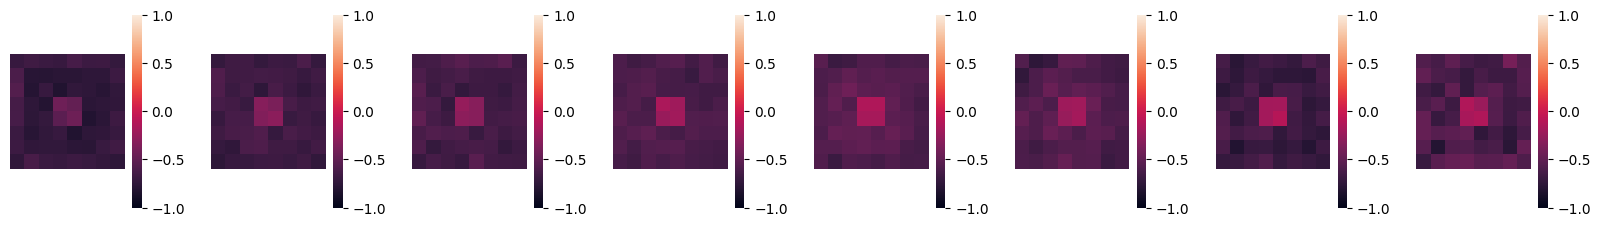

empty_yours


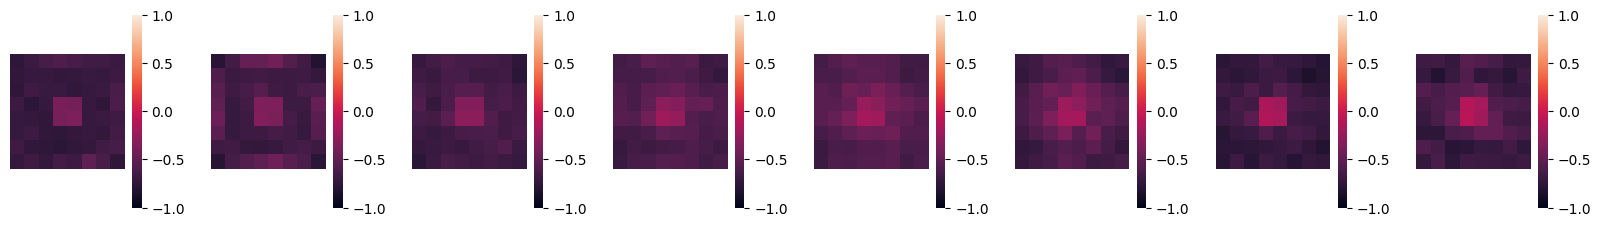

mine_yours


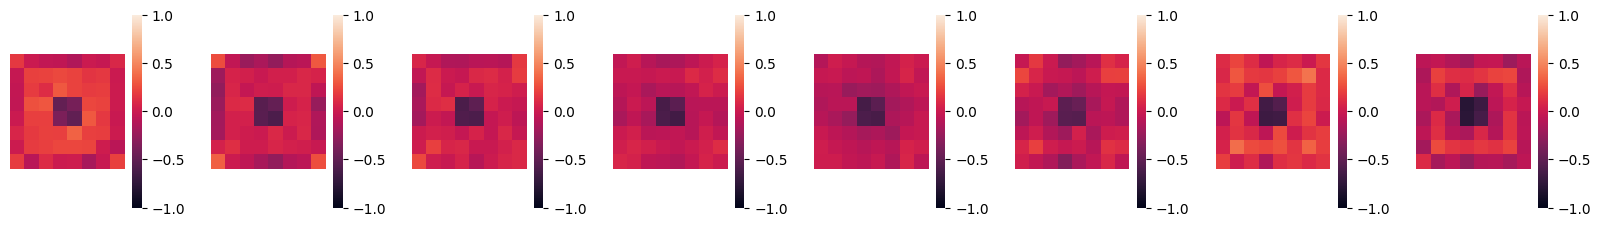

In [11]:
# Visualize the cosine similarities for each layer
def plot_cos_similarities(cos_similarities):
    """Plot the cosine similarities for each layer."""
    fig, axs = plt.subplots(1, 8, figsize=(20, 2.5))
    fig.subplots_adjust(wspace=0.4)
    for i in range(8):
        sns.heatmap(cos_similarities[i], ax=axs[i], square=True, cbar=True, vmin=-1, vmax=1)
        axs[i].set_xticks([])
        axs[i].set_yticks([])
    plt.show()


for option_pair, cos_similarities in linear_cos_similarities.items():
    print(option_pair)
    plot_cos_similarities(cos_similarities)

Layer 0


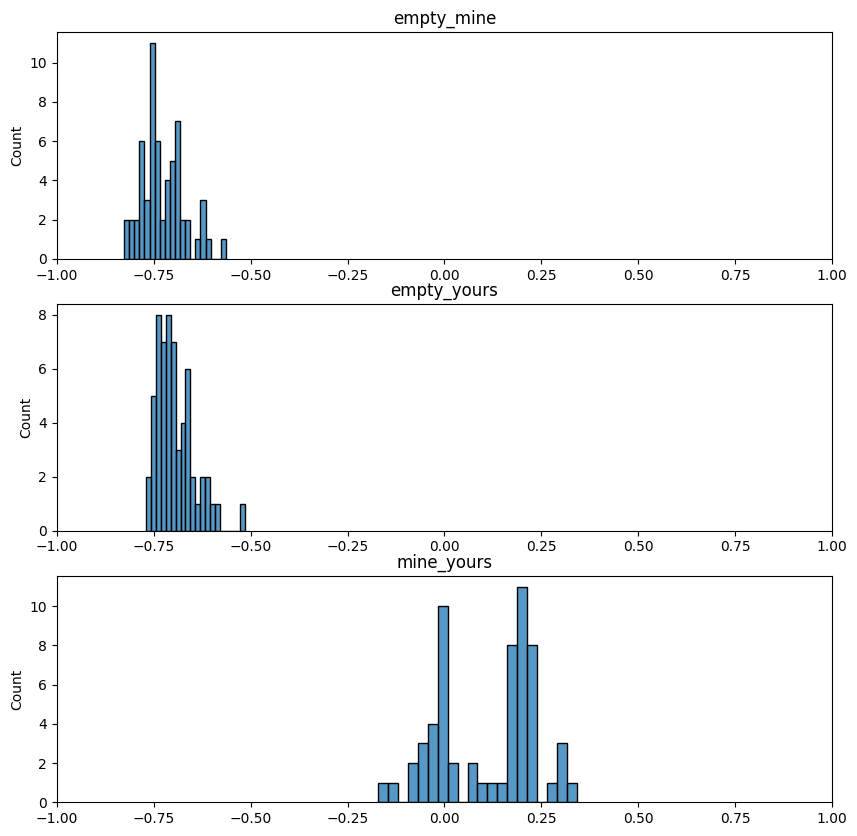

Layer 3


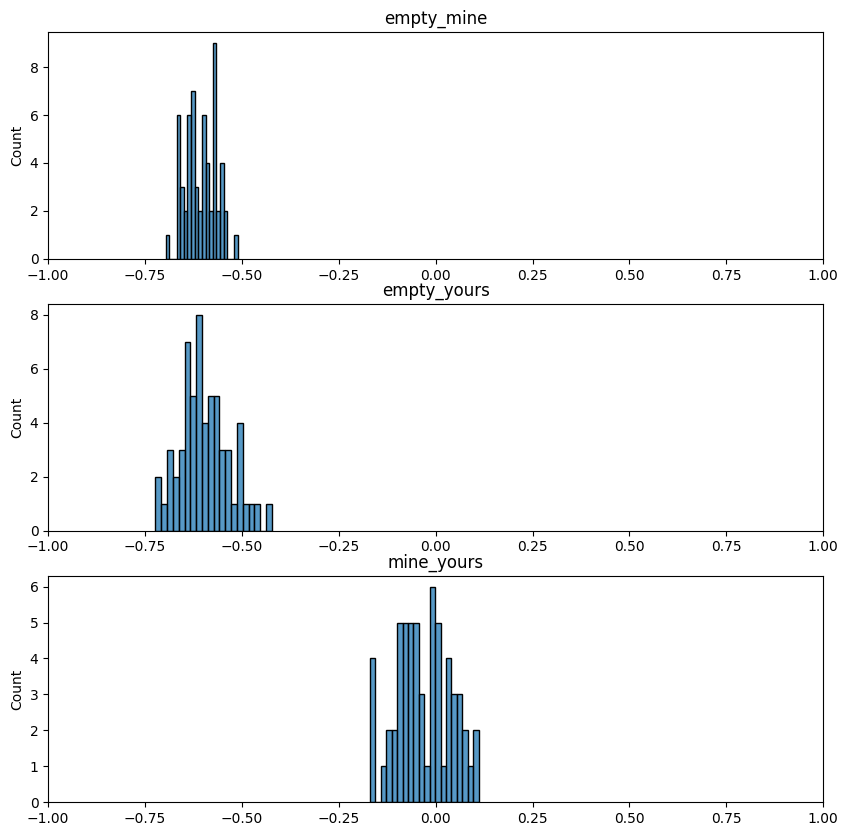

Layer 6


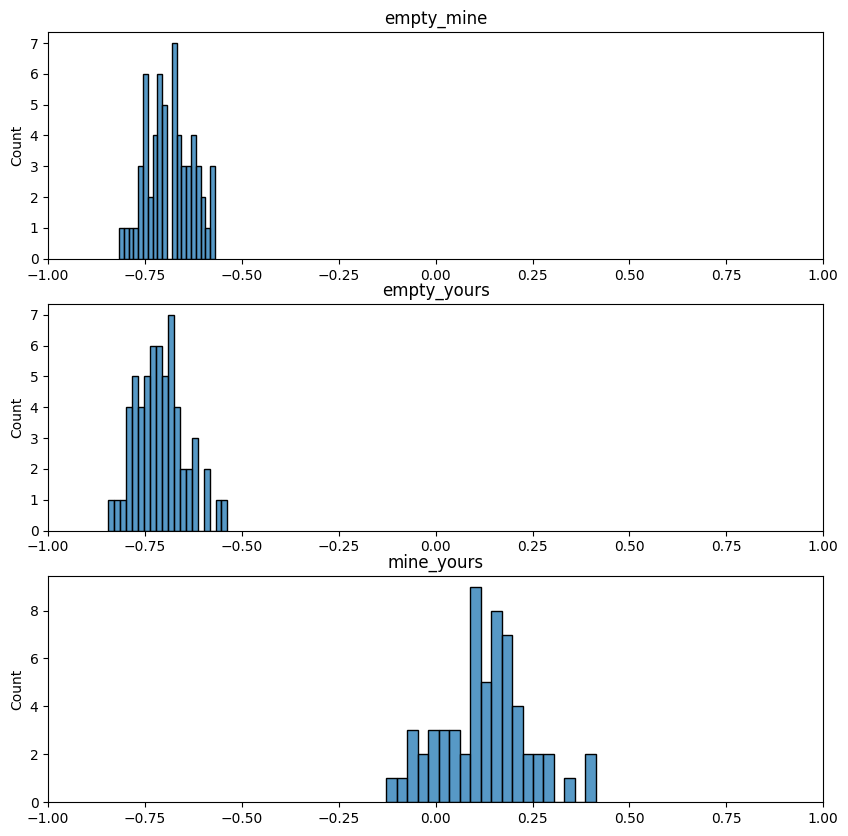

In [12]:
# Plot distributions of cosine similarities
def plot_cos_similarities_dist(cos_similarities, layer):
    """Plot the cosine similarities for one layer."""
    fig, axs = plt.subplots(3, 1, figsize=(10, 10))
    fig.subplots_adjust(wspace=0.4)

    for i, option_pair in enumerate(cos_similarities.keys()):
        similarities = cos_similarities[option_pair][layer].flatten()
        # Skip any starting cells
        similarities = similarities[NON_STARTING_SQUARES]
        sns.histplot(similarities, ax=axs[i], bins=20)
        axs[i].set_title(option_pair)
        axs[i].set_xlim(-1, 1)

    plt.show()


for layer in (0, 3, 6):
    print(f"Layer {layer}")
    plot_cos_similarities_dist(linear_cos_similarities, layer)

In [13]:
# Get cosine similarity of embeddings for each cell

model.embed.__dict__.keys()
embed_matrix = list(model.embed.parameters())[0]
ic(embed_matrix.shape)

embed_matrix_normed = F.normalize(embed_matrix, dim=1)
embed_cos_similarities = embed_matrix_normed @ embed_matrix_normed.T
ic(embed_cos_similarities.shape)

ic| embed_matrix.shape: torch.Size([61, 512])
ic| embed_cos_similarities.shape: torch.Size([61, 61])


torch.Size([61, 61])

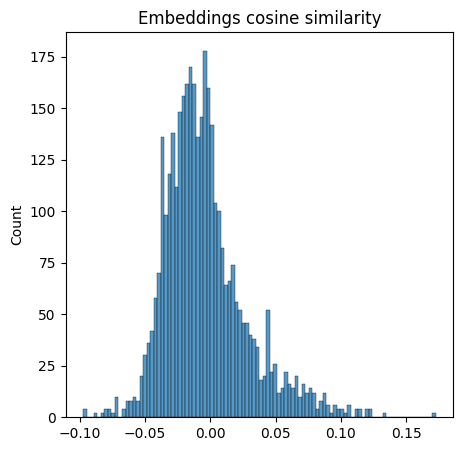

In [14]:
# Plot distributions of cosine similarities
def plot_embed_cos_similarities_dist(cos_similarities):
    """Plot the distribution of cosine similarities for embeddings."""
    fig, axs = plt.subplots(1, 1, figsize=(5, 5))
    # Skip any values on the diagonal
    similarities = cos_similarities[~torch.eye(cos_similarities.shape[0], dtype=bool)]
    sns.histplot(similarities, ax=axs, bins=100)
    axs.set_title("Embeddings cosine similarity")
    plt.show()


plot_embed_cos_similarities_dist(embed_cos_similarities)

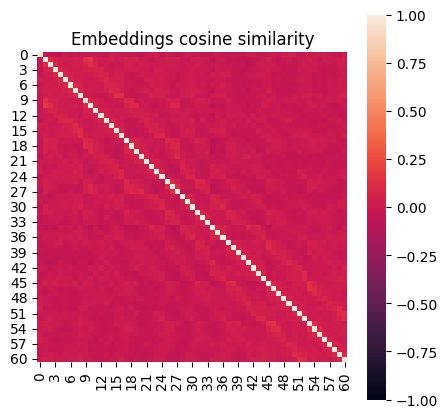

In [15]:
# Plot as heatmap
def plot_embed_cos_similarities_heatmap(cos_similarities):
    """Plot the heatmap of cosine similarities for embeddings."""
    fig, axs = plt.subplots(1, 1, figsize=(5, 5))
    sns.heatmap(cos_similarities, ax=axs, square=True, cbar=True, vmin=-1, vmax=1)
    plt.title("Embeddings cosine similarity")  
    plt.show()


plot_embed_cos_similarities_heatmap(embed_cos_similarities)

ic| embed_pca.shape: (60, 2)
ic| pca.explained_variance_: array([0.30832377, 0.28242502], dtype=float32)


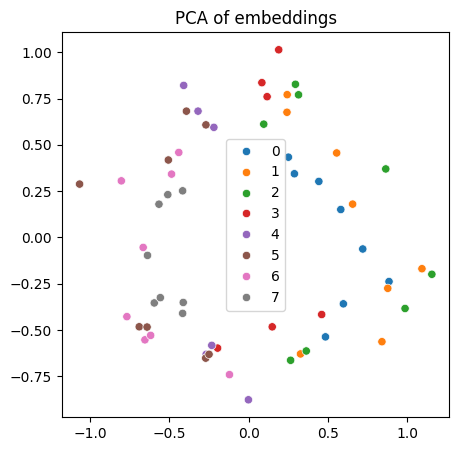

In [16]:
# Apply PCA to embeddings
pca = PCA(n_components=2)
embed_pca = pca.fit_transform(embed_matrix[1:].detach().numpy())
ic(embed_pca.shape)
ic(pca.explained_variance_)

# Plot PCA
def plot_pca(pca, color_by=None):
    """Plot the PCA of embeddings."""
    fig, axs = plt.subplots(1, 1, figsize=(5, 5))
    hue = get_cell_attributes(color_by) if color_by else None
    sns.scatterplot(x=pca[:, 0], y=pca[:, 1], hue=hue)
    plt.title("PCA of embeddings")
    plt.show()


plot_pca(embed_pca, color_by="col")

# In hindsight I should have seen this coming

In [17]:
# Replication: Train linear probe for first layer to check val accuracy matches
# value in paper (~90.9%)
train_config = {
    "model": "othello_gpt",
    "lr": 1e-2,
    "wd": 0.01,
    "rows": 8,
    "cols": 8,
    "valid_every": 200,
    "batch_size": 128,
    "pos_start": 0,
    "pos_end": 0,
    "num_epochs": 1,
    "valid_size": 512,
    "valid_patience": 10,
    "output_dir": str(NEW_PROBE_DIR / "linear"),
    "device": "mps"
}

try:
    train_linear(train_config)
    evaluate(train_config["output_dir"])
except Exception as e:
    print(e)

Using device: mps
Training layer 0!


  1%|▏         | 344/27344 [01:04<1:24:18,  5.34it/s, lowest_val_loss=12.8, patience=0, val_acc=0.909, val_loss=12.8]


KeyboardInterrupt: 

In [ ]:
# Note to Callum: DO NOT RE-RUN THIS CELL (output is nice)

# Train mid-layer probes (between attention and MLP) for each layer
train_config = {
    "model": "othello_gpt",
    "lr": 1e-2,
    "wd": 0.01,
    "rows": 8,
    "cols": 8,
    "valid_every": 200,
    "batch_size": 128,
    "pos_start": 0,
    "pos_end": 0,
    "num_epochs": 1,
    "valid_size": 512,
    "valid_patience": 10,
    "output_dir": str(MID_PROBE_DIR),
    "device": "mps",
}

train_mid(train_config)
evaluate_mid(train_config["output_dir"])

# Note to Callum: DO NOT RE-RUN THIS CELL (output is nice)

Starting at 2023-11-10 21:07:49.089046
Using device: mps
Training layer 0!


  8%|▊         | 2101/27344 [06:19<1:15:58,  5.54it/s, lowest_val_loss=15, patience=9, val_acc=0.889, val_loss=15]    


  Ran out of patience! Stopping training.
Training seen: 268928
Training layer 1!


  5%|▌         | 1376/27344 [04:06<1:17:25,  5.59it/s, lowest_val_loss=8.35, patience=9, val_acc=0.944, val_loss=8.35]


  Ran out of patience! Stopping training.
Training seen: 176128
Training layer 2!


  5%|▌         | 1376/27344 [04:05<1:17:09,  5.61it/s, lowest_val_loss=4.96, patience=9, val_acc=0.969, val_loss=4.96]


  Ran out of patience! Stopping training.
Training seen: 176128
Training layer 3!


  4%|▍         | 1101/27344 [03:16<1:18:00,  5.61it/s, lowest_val_loss=3.25, patience=9, val_acc=0.981, val_loss=3.27]


  Ran out of patience! Stopping training.
Training seen: 140928
Training layer 4!


  4%|▍         | 1101/27344 [03:16<1:18:04,  5.60it/s, lowest_val_loss=2.06, patience=9, val_acc=0.989, val_loss=2.08]


  Ran out of patience! Stopping training.
Training seen: 140928
Training layer 5!


  3%|▎         | 751/27344 [02:13<1:19:04,  5.61it/s, lowest_val_loss=1.33, patience=9, val_acc=0.994, val_loss=1.37]


  Ran out of patience! Stopping training.
Training seen: 96128
Training layer 6!


  3%|▎         | 751/27344 [02:14<1:19:23,  5.58it/s, lowest_val_loss=1.03, patience=9, val_acc=0.996, val_loss=1.08]


  Ran out of patience! Stopping training.
Training seen: 96128
Training layer 7!


  5%|▌         | 1476/27344 [04:23<1:16:55,  5.61it/s, lowest_val_loss=1.37, patience=9, val_acc=0.995, val_loss=1.38]


  Ran out of patience! Stopping training.
Training seen: 188928
F1_score: 0.8880383968353271
F1_score: 0.9428585767745972
F1_score: 0.9678016304969788
F1_score: 0.9801777005195618
F1_score: 0.9882107973098755
F1_score: 0.992827832698822
F1_score: 0.9948665499687195
F1_score: 0.9936014413833618


In [8]:
(accs_linear,
 per_timestep_num_correct_linear,
 f1_linear,
 f1_score_by_class_linear) = evaluate(LINEAR_PROBE_DIR, device="mps")

ic(len(accs_linear), torch.mean(accs_linear))
ic(per_timestep_num_correct_linear[0].shape)
ic(f1_score_by_class_linear.mean(axis=0))

(accs_mid,
 per_timestep_num_correct_mid,
 f1_mid,
 f1_score_by_class_mid) = evaluate(MID_PROBE_DIR, hook="resid_mid", device="mps")

ic(len(accs_mid), torch.mean(accs_mid))
ic(per_timestep_num_correct_mid[0].shape)
ic(f1_score_by_class_mid.mean(axis=0))

Evaluating layer 0


100%|██████████| 8/8 [00:03<00:00,  2.54it/s]


Evaluating layer 1


100%|██████████| 8/8 [00:00<00:00,  9.96it/s]


Evaluating layer 2


100%|██████████| 8/8 [00:00<00:00,  9.90it/s]


Evaluating layer 3


100%|██████████| 8/8 [00:00<00:00,  9.95it/s]


Evaluating layer 4


100%|██████████| 8/8 [00:00<00:00,  9.93it/s]


Evaluating layer 5


100%|██████████| 8/8 [00:00<00:00,  9.92it/s]


Evaluating layer 6


100%|██████████| 8/8 [00:00<00:00,  9.95it/s]


Evaluating layer 7


100%|██████████| 8/8 [00:00<00:00,  9.93it/s]
ic| len(accs_linear): 8, torch.mean(accs_linear): tensor(0.9722)
ic| per_timestep_num_correct_linear[0].shape: torch.Size([59, 8, 8])
ic| f1_score_by_class_linear.mean(axis=0): tensor([0.9997, 0.9519, 0.9433])


Evaluating layer 0


100%|██████████| 8/8 [00:01<00:00,  4.24it/s]


Evaluating layer 1


100%|██████████| 8/8 [00:00<00:00,  9.93it/s]


Evaluating layer 2


100%|██████████| 8/8 [00:00<00:00,  9.92it/s]


Evaluating layer 3


100%|██████████| 8/8 [00:00<00:00,  9.93it/s]


Evaluating layer 4


100%|██████████| 8/8 [00:00<00:00,  9.92it/s]


Evaluating layer 5


100%|██████████| 8/8 [00:00<00:00,  9.93it/s]


Evaluating layer 6


100%|██████████| 8/8 [00:00<00:00,  9.92it/s]


Evaluating layer 7


100%|██████████| 8/8 [00:00<00:00,  9.78it/s]
ic| len(accs_mid): 8, torch.mean(accs_mid): tensor(0.9685)
ic| per_timestep_num_correct_mid[0].shape: torch.Size([59, 8, 8])
ic| f1_score_by_class_mid.mean(axis=0): tensor([0.9999, 0.9455, 0.9355])


tensor([0.9999, 0.9455, 0.9355])

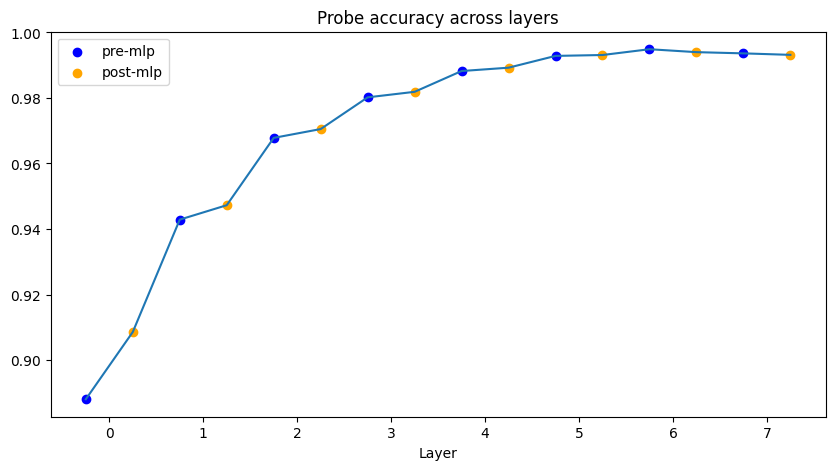

F1 for empty


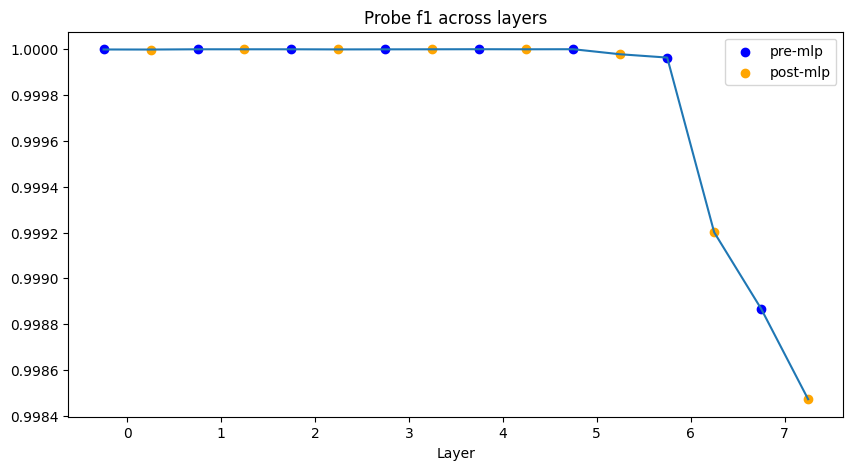

F1 for mine


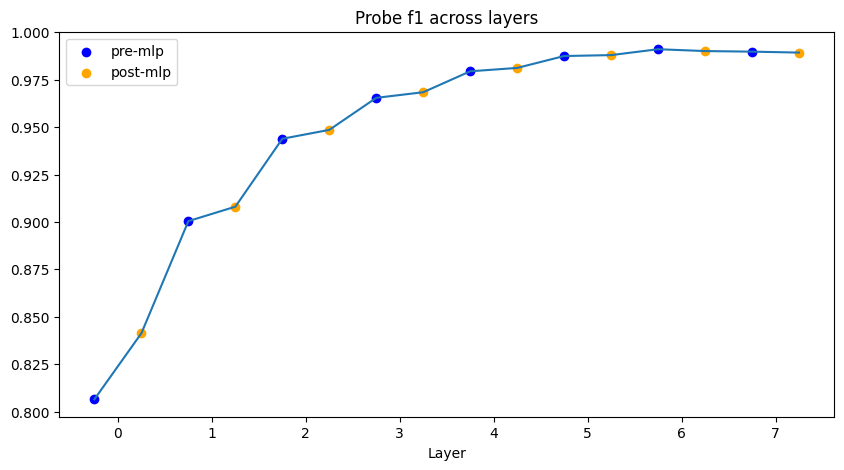

F1 for yours


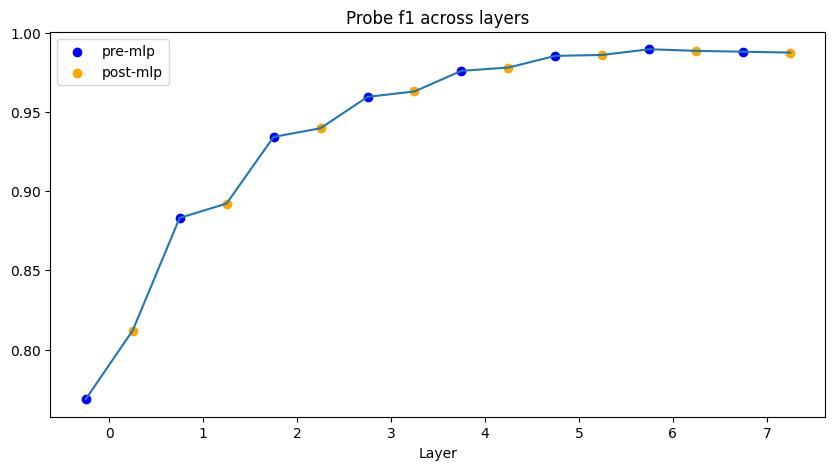

In [11]:
# Plot across layers
def plot_metrics(accs_mid, accs_post, metric="accuracy", extra=""):
    # Interleave the two accs lists
    accs_all = [acc.item() for pair in zip(accs_mid, accs_post) for acc in pair]
    x_labels = list(range(8))

    fig, axs = plt.subplots(1, 1, figsize=(10, 5))
    sns.lineplot(x=range(len(accs_all)), y=accs_all, ax=axs)
    axs.set_title(f"Probe {metric}{extra} across layers")
    axs.set_xticks(2 * np.arange(len(x_labels)) + 0.5)
    axs.set_xticklabels(x_labels)
    axs.set_xlabel("Layer")

    # Plot scatter points coloured by mid or post
    pre_xs = [i for i in range(len(accs_all)) if i % 2 == 0]
    pre_ys = [accs_all[i] for i in range(len(accs_all)) if i % 2 == 0]
    axs.scatter(pre_xs, pre_ys, c="blue", label="pre-mlp")
    post_xs = [i for i in range(len(accs_all)) if i % 2 == 1]
    post_ys = [accs_all[i] for i in range(len(accs_all)) if i % 2 == 1]
    axs.scatter(post_xs, post_ys, c="orange", label="post-mlp")
    plt.legend()
    plt.show()


plot_metrics(accs_mid, accs_linear)

for i, option in enumerate(["empty", "mine", "yours"]):
    plot_metrics(
        f1_score_by_class_mid[:, i],
        f1_score_by_class_linear[:, i],
        metric="f1",
        extra=f" for {option}",
    )

In [24]:
def get_interventions(probe_dir, hook):
    """Get interventions for bottom N and top N layers."""
    print(f"Probe dir: {probe_dir}, hook: {hook}")
    interventions = []
    pbar = trange(8)
    for top_layer in pbar:
        layers = list(range(top_layer + 1))
        pbar.description = f"Top layer: {top_layer}"
        interventions.append(intervene(
            probe_dir,
            layers,
            hook=hook,
            device="mps",
        ))
    pbar = trange(7, 0, -1)
    for bottom_layer in pbar:
        layers = list(range(bottom_layer, 8))
        pbar.postfix = f"Bottom layer: {bottom_layer}"
        interventions.append(intervene(
            probe_dir,
            layers,
            hook=hook,
            device="mps",
        ))
    # intervention errors and null errors
    return [x[0] for x in interventions], [x[1] for x in interventions]


errs_mid, null_mid = get_interventions(MID_PROBE_DIR, "resid_mid")
errs_post, null_post = get_interventions(LINEAR_PROBE_DIR, "resid_post")

ic(errs_mid, null_mid, errs_post, null_post)

100%|██████████| 1/1 [00:00<00:00, 100.02it/s]


Dataset created has 1 sequences, 61 unique words.
Probe dir: new_probes/mid, hook: resid_mid


100%|██████████| 7/7 [10:43<00:00, 91.94s/it, Bottom layer: 1]


Probe dir: mech_int_othelloGPT/mech_int/probes/linear, hook: resid_post


100%|██████████| 7/7 [10:41<00:00, 91.66s/it, Bottom layer: 1]
ic| errs_mid: [2.675324675324675,
               2.3996003996003994,
               1.966033966033966,
               0.9310689310689311,
               0.3156843156843157,
               0.2017982017982018,
               0.15984015984015984,
               0.15584415584415584,
               2.7092907092907095,
               2.4275724275724277,
               1.5064935064935066,
               0.2597402597402597,
               0.10589410589410589,
               0.1018981018981019,
               0.13786213786213786]
    null_mid: [2.723276723276723,
               2.723276723276723,
               2.723276723276723,
               2.723276723276723,
               2.723276723276723,
               2.723276723276723,
               2.723276723276723,
               2.723276723276723,
               2.723276723276723,
               2.723276723276723,
               2.723276723276723,
               2.723276723276723,
  

([2.675324675324675,
  2.3996003996003994,
  1.966033966033966,
  0.9310689310689311,
  0.3156843156843157,
  0.2017982017982018,
  0.15984015984015984,
  0.15584415584415584,
  2.7092907092907095,
  2.4275724275724277,
  1.5064935064935066,
  0.2597402597402597,
  0.10589410589410589,
  0.1018981018981019,
  0.13786213786213786],
 [2.723276723276723,
  2.723276723276723,
  2.723276723276723,
  2.723276723276723,
  2.723276723276723,
  2.723276723276723,
  2.723276723276723,
  2.723276723276723,
  2.723276723276723,
  2.723276723276723,
  2.723276723276723,
  2.723276723276723,
  2.723276723276723,
  2.723276723276723,
  2.723276723276723],
 [2.6693306693306695,
  2.3196803196803195,
  1.2047952047952049,
  0.3756243756243756,
  0.1958041958041958,
  0.13586413586413587,
  0.1258741258741259,
  0.12387612387612387,
  2.5534465534465536,
  2.5234765234765235,
  2.125874125874126,
  1.3786213786213786,
  0.22377622377622378,
  0.07592407592407592,
  0.08191808191808192],
 [2.723276723276

In [ ]:
# Plot interventions
def plot_interventions(interventions, metric="accuracy"):
    """Plot interventions."""
    fig, axs = plt.subplots(1, 1, figsize=(10, 5))
    sns.lineplot(x=range(len(interventions)), y=interventions, ax=axs)
    axs.set_title(f"Probe {metric} across layers")
    axs.set_xticks(2 * np.arange(8) + 0.5)
    axs.set_xticklabels(list(range(8)))
    axs.set_xlabel("Layer")
    plt.show()


plot_interventions(interventions_mid)
plot_interventions(interventions_linear)